## Simulate a catolog for the lensed SN pipeline
Outputs: z_lens, z_source, theta_E, MJD (list), bandpasses (list), fiveSigmaDepth (list), FWHMeff (list), filtSkyBrightness (list)

In [8]:
import numpy as np
import sys
import time
import os
import opsimsummary as oss
import healpy as hp
from opsimsummary import SynOpSim
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import astropy.units as u
import pickle
import astropy
import pandas as pd
plt.rc("font", family="serif")
plt.rc("text", usetex=True)

### Load redshifts and Einstein radii

In [2]:
def load_z_theta(theta_min=0.1, zsrc_max=1.5):
    """
    Download joint distribution of source redshift, lens redshift and Einstein radius for configurations where
    strong lensing occurs. Distribution is obtained from the lensed supernova simulation by Wojtek et al. (2019).

    :param theta_min: minimum accepted value of the einstein radius
    :param zsrc_max: maximum accepted value of the source redshift
    :return: z_source_list_: array containing ~ 400,000 values of the source redshift
             z_lens_list_: array containing ~ 400,000 values of the lens redshift
             theta_E_list_: array containing ~ 400,000 values of the einstein radius
    """

    zlens_zSN_theta = np.load("../data/sample_zl_zsn_theta.npz")['zlens_zSN_theta']
    zlens_zSN_theta = np.repeat(zlens_zSN_theta, 3, axis=0)

    z_source_list_ = []
    z_lens_list_ = []
    theta_E_list_ = []

    for m in range(zlens_zSN_theta.shape[0]):
        if zlens_zSN_theta[m, 1] < zsrc_max and zlens_zSN_theta[m, 1] > zlens_zSN_theta[m, 0] and \
                zlens_zSN_theta[m, 2] > theta_min and zlens_zSN_theta[m, 1] > 0 and zlens_zSN_theta[m, 0] > 0:
            z_source_list_.append(zlens_zSN_theta[m, 1])
            z_lens_list_.append(zlens_zSN_theta[m, 0])
            theta_E_list_.append(zlens_zSN_theta[m, 2])

    return np.array(z_source_list_), np.array(z_lens_list_), np.array(theta_E_list_)


def sample_z_theta(z_source_list_, z_lens_list_, theta_E_list_, sample):
    """
    Selects the values of z_lens, z_source and theta_E for the current lens system.

    :param z_source_list_: array containing the source redshift values used in the simulation
    :param z_lens_list_: array containing the lens redshift values used in the simulation
    :param theta_E_list_: array containing the einstein radius values used in the simulation
    :param sample: array containing the indices of (zlens, zsrc, theta) combinations to be used in this run of
                   the simulation
    :param sample_index: counts which configuration from the sample array to select
    :return: the resulting values of z_source, z_lens and theta_E (floats) to be used for the current lens system
    """
    z_source = z_source_list_[sample]
    z_lens = z_lens_list_[sample]
    theta_E = theta_E_list_[sample]

    return z_source, z_lens, theta_E

In [3]:
N_samples = 100

# Load joint theta_E, z_lens, z_source distribution
z_source_list_, z_lens_list_, theta_E_list_ = load_z_theta(theta_min=0.05)

# Sample num_samples from the joint z_lens, z_source, theta_E distribution
sample = np.random.choice(len(z_source_list_), N_samples, replace=False)
z_source, z_lens, theta_E = sample_z_theta(z_source_list_, z_lens_list_, theta_E_list_, sample)

Text(0, 0.5, 'Counts')

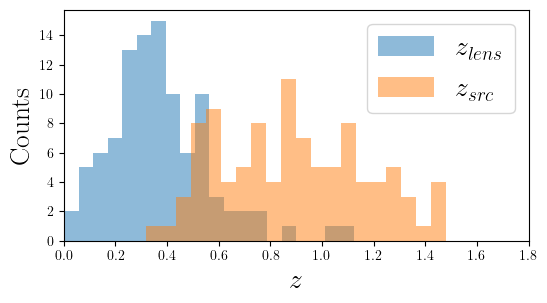

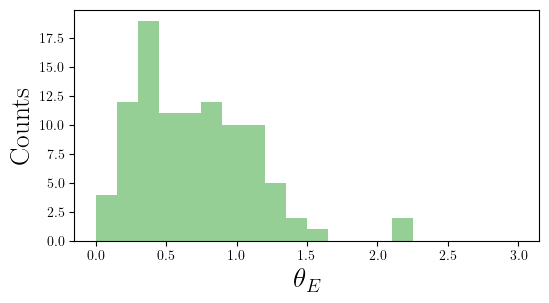

In [4]:
bins = 20

plt.figure(figsize=(6,3))
plt.hist(z_lens, bins=bins, alpha=0.5, label=r'$z_{lens}$')
plt.hist(z_source, bins=bins, alpha=0.5, label=r'$z_{src}$')
plt.legend(fontsize=20)
plt.xlabel(r"$z$", fontsize=20)
plt.ylabel("Counts", fontsize=20)
plt.xlim(0, 1.8)

plt.figure(figsize=(6,3))
plt.hist(theta_E, bins=bins, alpha=0.5, label=r'$\theta_{E}$', color="C2", range=(0,3))
plt.xlabel(r"$\theta_{E}$", fontsize=20)
plt.ylabel("Counts", fontsize=20)
#plt.xlim(0, 1.8)

### Get OpSim observations

In [5]:
def create_sky_pointings(N, dec_low=-90, dec_high=40):
    """
    Creates random points on a sphere (with limited declination).
    Acception fraction of points is around 2/3, so sample ~1.6 times as many points.
    """
    
    sample_number = int(N * 1.6)
    print(sample_number, " pointings created")
    ra_points = np.random.uniform(low=0, high=360, size=sample_number)
    dec_points = np.arcsin(2 * np.random.uniform(size=sample_number) - 1) / np.pi * 180

    dec_selection = (dec_points > dec_low) & (dec_points < dec_high)
    ra_points = ra_points[dec_selection]
    dec_points = dec_points[dec_selection]

    return ra_points, dec_points


def initialise_opsim_summary(ra_pointings, dec_pointings):
    myopsimv3 = '../data/OpSim_databases/baseline_v3.0_10yrs.db'
    
    synopsim = SynOpSim.fromOpSimDB(myopsimv3, opsimversion='fbsv2', usePointingTree=True, use_proposal_table=False,
                               subset='unique_all')
    
    gen = synopsim.pointingsEnclosing(ra_pointings, dec_pointings, circRadius=0., pointingRadius=1.75, 
                                  usePointingTree=True)
    return gen


def opsim_observation(gen):
    
    while True:
    
        obs = next(gen)
        opsim_ra = np.mean(obs['fieldRA'])
        opsim_dec = np.mean(obs['fieldDec'])

        if np.isnan(opsim_ra) or np.isnan(opsim_dec):
            continue
                
        obs = obs.sort_values(by=['expMJD'])
        
        opsim_times = obs['expMJD']
        opsim_filters = obs['filter']
        opsim_psf = obs['seeingFwhmGeom']
        opsim_lim_mag = obs['fiveSigmaDepth']
        opsim_sky_brightness = obs['filtSkyBrightness']
        break

    return opsim_ra, opsim_dec, opsim_times, opsim_filters, opsim_psf, opsim_lim_mag, opsim_sky_brightness


def select_operation_years(times, filters, psf, lim_mag, sky_brightness, mjd_cutoff=61325):
    
    indices = times < mjd_cutoff
    
    return times[indices], filters[indices], psf[indices], lim_mag[indices], sky_brightness[indices]

In [6]:
# Initialise OpSim
ra_pointings, dec_pointings = create_sky_pointings(N=1000)
gen = initialise_opsim_summary(ra_pointings, dec_pointings)


1600  pointings created
 reading from database sqlite:///../data/OpSim_databases/baseline_v3.0_10yrs.db
We have filterNull set to False
checking that summary table read in

Reading in raw tables successful
replacing names works
dropping duplicates works
dithered column names exists 
Changing units for fbsv2 from degrees


In [7]:
opsim_mjd = []
opsim_filter = []
opsim_psf = []
opsim_limmag = []
opsim_skybrightness = []

for i in range(100):
    
    # Get OpSim observations
    ra, dec, times, filters, psf, lim_mag, sky_brightness = opsim_observation(gen)

    # Cut out everything after year 3
    times, filters, psf, lim_mag, sky_brightness = select_operation_years(times, filters, psf, lim_mag, sky_brightness)

    opsim_mjd.append(np.array(times))
    opsim_filter.append(np.array(filters))
    opsim_psf.append(np.array(psf))
    opsim_limmag.append(np.array(lim_mag))
    opsim_skybrightness.append(np.array(sky_brightness))
    

check using ptree True


In [10]:
len(opsim_mjd)

100

### Save the catalog

In [16]:
catalog = pd.DataFrame(
    {'z_lens': z_lens,
     'z_source': z_source,
     'theta_E': theta_E,
     'MJD': opsim_mjd,
     'filter': opsim_filter,
     'fiveSigmaDepth': opsim_limmag,
     'FWHMeff': opsim_psf,
     'filtSkyBrightness': opsim_skybrightness
    })

In [17]:
catalog

,z_lens,z_source,theta_E,MJD,filter,fiveSigmaDepth,FWHMeff,filtSkyBrightness
0,0.363235,0.914758,0.085192,"[60218.00536220441, 60218.02935750629, 60218.1...","[r, i, i, y, y, z, y, z, z, i, i, y, y, r, i, ...","[23.075882421423902, 22.808636062573015, 22.08...","[2.039766543836286, 1.2813376214896168, 2.3836...","[21.06401036574868, 19.583019937870965, 19.459..."
1,0.520138,1.047860,0.345886,"[60222.38702843169, 60222.39012755702, 60230.3...","[r, r, r, r, r, y, y, z, y, i, r, i, r, i, r, ...","[22.55805485840376, 22.443190406752493, 22.978...","[1.0379190443685438, 1.025012709286732, 1.0793...","[19.230396072858873, 18.951173689454773, 20.16..."
2,0.436605,1.342281,0.852509,"[60280.33954255666, 60280.35151665867, 60289.3...","[y, y, y, y, y, y, r, i, i, i, z, y, y, r, i, ...","[22.192741920880255, 21.851020776248077, 22.43...","[0.7444479053764209, 0.7619795151650784, 0.668...","[18.316327575887158, 17.64938490719234, 18.539..."
3,0.850174,1.096331,0.313550,"[60223.36742495892, 60223.367872320014, 60223....","[y, y, y, y, i, z, y, i, r, y, y, y, i, i, z, ...","[22.024879754130815, 22.02748118227191, 22.057...","[0.866361539612348, 0.864739440293785, 0.79761...","[18.38792774098494, 18.38731307007911, 18.2738..."
4,0.167639,0.637901,1.449804,"[60219.32152212282, 60219.34388662985, 60222.2...","[y, y, y, y, z, i, z, z, z, i, i, i, i, r, i, ...","[21.521581581638266, 21.499816946791217, 22.38...","[1.2853962312388332, 1.230315358703621, 0.6718...","[18.283685467912882, 18.18527467098175, 18.471..."
...,...,...,...,...,...,...,...,...
95,0.402528,1.119724,0.799651,"[60229.992003784166, 60229.993200335484, 60229...","[r, r, r, r, r, r, r, r, i, i, i, i, y, y, y, ...","[22.44783552127441, 22.61536791843666, 22.8053...","[1.383329766785458, 1.3449153645824266, 1.1984...","[19.63058283948792, 19.894280106906194, 20.055..."
96,0.344134,0.813297,0.337441,"[60411.42017578796, 60423.384709888196, 60423....","[y, y, y, y, y, i, i, z, y, r, r, i, i, i, z, ...","[21.406835814150377, 21.48682498733049, 22.011...","[0.8421235630633661, 1.239546276790972, 0.7918...","[17.095885019381686, 18.158094066879464, 18.17..."
97,0.291445,1.383320,0.532459,"[60365.380279299105, 60365.38208730917, 60365....","[y, y, y, y, y, r, i, z, r, r, r, i, r, z, i, ...","[22.29668219964125, 22.369534050474037, 22.321...","[0.7055443800440624, 0.653928568965872, 0.6121...","[18.383246277060305, 18.35047993087383, 18.082..."
98,0.389684,0.801501,0.318691,"[60334.33531389389, 60336.34969231489, 60336.3...","[y, y, y, r, i, r, i, r, i, z, y, z, y, y, z, ...","[22.107134227180353, 22.2459307859889, 22.4439...","[0.7957977364973426, 0.7232619633732563, 0.614...","[18.313189653040357, 18.34853417170238, 18.352..."


In [18]:
# Save as pickle

catalog.to_pickle("../processed_data/lensed_SN_pipeline/lensed_SN_catalog_100.pkl")

In [19]:
with open("../processed_data/lensed_SN_pipeline/lensed_SN_catalog_100.pkl", 'rb') as f:
    df = pickle.load(f)

In [20]:
df

,z_lens,z_source,theta_E,MJD,filter,fiveSigmaDepth,FWHMeff,filtSkyBrightness
0,0.363235,0.914758,0.085192,"[60218.00536220441, 60218.02935750629, 60218.1...","[r, i, i, y, y, z, y, z, z, i, i, y, y, r, i, ...","[23.075882421423902, 22.808636062573015, 22.08...","[2.039766543836286, 1.2813376214896168, 2.3836...","[21.06401036574868, 19.583019937870965, 19.459..."
1,0.520138,1.047860,0.345886,"[60222.38702843169, 60222.39012755702, 60230.3...","[r, r, r, r, r, y, y, z, y, i, r, i, r, i, r, ...","[22.55805485840376, 22.443190406752493, 22.978...","[1.0379190443685438, 1.025012709286732, 1.0793...","[19.230396072858873, 18.951173689454773, 20.16..."
2,0.436605,1.342281,0.852509,"[60280.33954255666, 60280.35151665867, 60289.3...","[y, y, y, y, y, y, r, i, i, i, z, y, y, r, i, ...","[22.192741920880255, 21.851020776248077, 22.43...","[0.7444479053764209, 0.7619795151650784, 0.668...","[18.316327575887158, 17.64938490719234, 18.539..."
3,0.850174,1.096331,0.313550,"[60223.36742495892, 60223.367872320014, 60223....","[y, y, y, y, i, z, y, i, r, y, y, y, i, i, z, ...","[22.024879754130815, 22.02748118227191, 22.057...","[0.866361539612348, 0.864739440293785, 0.79761...","[18.38792774098494, 18.38731307007911, 18.2738..."
4,0.167639,0.637901,1.449804,"[60219.32152212282, 60219.34388662985, 60222.2...","[y, y, y, y, z, i, z, z, z, i, i, i, i, r, i, ...","[21.521581581638266, 21.499816946791217, 22.38...","[1.2853962312388332, 1.230315358703621, 0.6718...","[18.283685467912882, 18.18527467098175, 18.471..."
...,...,...,...,...,...,...,...,...
95,0.402528,1.119724,0.799651,"[60229.992003784166, 60229.993200335484, 60229...","[r, r, r, r, r, r, r, r, i, i, i, i, y, y, y, ...","[22.44783552127441, 22.61536791843666, 22.8053...","[1.383329766785458, 1.3449153645824266, 1.1984...","[19.63058283948792, 19.894280106906194, 20.055..."
96,0.344134,0.813297,0.337441,"[60411.42017578796, 60423.384709888196, 60423....","[y, y, y, y, y, i, i, z, y, r, r, i, i, i, z, ...","[21.406835814150377, 21.48682498733049, 22.011...","[0.8421235630633661, 1.239546276790972, 0.7918...","[17.095885019381686, 18.158094066879464, 18.17..."
97,0.291445,1.383320,0.532459,"[60365.380279299105, 60365.38208730917, 60365....","[y, y, y, y, y, r, i, z, r, r, r, i, r, z, i, ...","[22.29668219964125, 22.369534050474037, 22.321...","[0.7055443800440624, 0.653928568965872, 0.6121...","[18.383246277060305, 18.35047993087383, 18.082..."
98,0.389684,0.801501,0.318691,"[60334.33531389389, 60336.34969231489, 60336.3...","[y, y, y, r, i, r, i, r, i, z, y, z, y, y, z, ...","[22.107134227180353, 22.2459307859889, 22.4439...","[0.7957977364973426, 0.7232619633732563, 0.614...","[18.313189653040357, 18.34853417170238, 18.352..."
